# CDFS SWIRE master catalogue
## Preparation of PanSTARRS data

Isaac Newton Telescope / Wide Field Camera (INT/WFC) catalogue: the catalogue comes from `dmu0_PanSTARRS1-3SS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The aperture magnitude
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
a03d5b3 (Wed Jul 5 12:19:29 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "ps1_ra"
DEC_COL = "ps1_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
    'uniquePspsSTid':'ps1_id', 
    'rra':'ps1_ra', 
    'rdec':'ps1_dec',   
    'gApMag':'m_ap_ps1_g', 
    'gApMagErr':'merr_ap_ps1_g', 
    'gKronMag':'m_ps1_g', 
    'gKronMagErr':'merr_ps1_g', 
    'rApMag':'m_ap_ps1_r', 
    'rApMagErr':'merr_ap_ps1_r', 
    'rKronMag':'m_ps1_r', 
    'rKronMagErr':'merr_ps1_r',
    'iApMag':'m_ap_ps1_i', 
    'iApMagErr':'merr_ap_ps1_i', 
    'iKronMag':'m_ps1_i', 
    'iKronMagErr':'merr_ps1_i',
    'zApMag':'m_ap_ps1_z', 
    'zApMagErr':'merr_ap_ps1_z', 
    'zKronMag':'m_ps1_z', 
    'zKronMagErr':'merr_ps1_z',
    'yApMag':'m_ap_ps1_y', 
    'yApMagErr':'merr_ap_ps1_y', 
    'yKronMag':'m_ps1_y', 
    'yKronMagErr':'merr_ps1_y'
    })


catalogue = Table.read("../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_CDFS-SWIRE.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2009

# Clean table metadata
catalogue.meta = None

In [5]:
# Replace values with -999. with NaN
#ps1[ps1 == -999.] = np.nan #fancy numpy doesn't work
for col in catalogue.colnames:
    if col.startswith('m'): # | col.endswith('ra') | col.endswith('dec'):
        catalogue[col][np.where(catalogue[col] == -999.)] = np.nan

# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))

        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [6]:
catalogue[:10].show_in_notebook()

idx,ps1_id,ps1_ra,ps1_dec,m_ap_ps1_g,merr_ap_ps1_g,m_ps1_g,merr_ps1_g,m_ap_ps1_r,merr_ap_ps1_r,m_ps1_r,merr_ps1_r,m_ap_ps1_i,merr_ap_ps1_i,m_ps1_i,merr_ps1_i,m_ap_ps1_z,merr_ap_ps1_z,m_ps1_z,merr_ps1_z,m_ap_ps1_y,merr_ap_ps1_y,m_ps1_y,merr_ps1_y,f_ap_ps1_g,ferr_ap_ps1_g,flag_ap_ps1_g,f_ps1_g,ferr_ps1_g,flag_ps1_g,f_ap_ps1_r,ferr_ap_ps1_r,flag_ap_ps1_r,f_ps1_r,ferr_ps1_r,flag_ps1_r,f_ap_ps1_i,ferr_ap_ps1_i,flag_ap_ps1_i,f_ps1_i,ferr_ps1_i,flag_ps1_i,f_ap_ps1_z,ferr_ap_ps1_z,flag_ap_ps1_z,f_ps1_z,ferr_ps1_z,flag_ps1_z,f_ap_ps1_y,ferr_ap_ps1_y,flag_ap_ps1_y,f_ps1_y,ferr_ps1_y,flag_ps1_y
0,1044575000001629,52.52906269,-28.00194851,23.5210990906,0.021276999265,nan,nan,nan,0.012261999771,21.4883995056,0.123677000403,nan,0.00909699965268,nan,nan,21.6175994873,0.00822700001299,nan,nan,20.8388996124,0.005795000121,nan,nan,1.41762173685,0.0277809071123,False,nan,nan,False,nan,nan,False,9.21807416052,1.05003752907,False,nan,nan,False,nan,nan,False,8.18389794665,0.0620122348489,False,nan,nan,False,16.7664128178,0.0894889236283,False,nan,nan,False
1,1044575000000385,52.5315548,-28.00073337,nan,0.0181089993566,nan,nan,nan,0.00812599994242,21.9500007629,0.163737997413,nan,0.0118119996041,nan,nan,23.0020008087,0.0155649995431,nan,nan,nan,0.0148600004613,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,6.0255916266,0.908709041701,False,nan,nan,False,nan,nan,False,2.2866498997,0.0327811714191,False,nan,nan,False,nan,nan,False,nan,nan,False
2,1044031000004158,52.53204583,-28.00106594,nan,0.0184179991484,nan,nan,nan,0.0889360010624,nan,nan,23.0331001282,0.0100750001147,22.9598007202,0.302852988243,21.5739002228,0.00722299981862,nan,nan,nan,0.0197410006076,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,2.2220813213,0.020619621478,False,2.37727658017,0.663112561807,False,8.52000620169,0.056680437642,False,nan,nan,False,nan,nan,False,nan,nan,False
3,1044575000001637,52.53203882,-28.00106933,nan,0.019756000489,nan,nan,nan,0.00677399989218,nan,nan,22.8180999756,0.00951300002635,22.7593002319,0.246711999178,21.5007991791,0.00779600022361,nan,nan,23.3540992737,0.0184550005943,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,2.70869439931,0.0237330299746,False,2.85943288329,0.649749359061,False,9.11339781509,0.0654376736199,False,nan,nan,False,1.6533328337,0.0281028285643,False,nan,nan,False
4,1044031000001432,52.53986429,-28.00321425,22.7817001343,0.0133130000904,nan,nan,22.9813995361,0.0137729998678,nan,nan,21.7229995728,0.00551000004634,22.0044002533,0.134818002582,23.3511009216,0.0163739994168,nan,nan,22.9706993103,0.0138830002397,nan,nan,2.80104409886,0.0343456358717,False,nan,nan,False,2.33045212498,0.029562721284,False,nan,nan,False,7.42677335964,0.0376901142068,False,5.73112523546,0.711645106245,False,1.65790496194,0.0250028826164,False,nan,nan,False,2.35353291191,0.0300939563746,False,nan,nan,False
5,1044575000000405,52.53986334,-28.00321892,22.6770000458,0.0144239999354,nan,nan,nan,0.0168180000037,nan,nan,21.7572002411,0.00583600020036,21.9636001587,0.136280998588,23.129699707,0.0165069997311,nan,nan,21.5256004333,0.00795099977404,nan,nan,3.08460800771,0.0409790016294,False,nan,nan,False,nan,nan,False,nan,nan,False,7.19647636771,0.0386821746754,False,5.9505887454,0.746914557011,False,2.03291919807,0.0309075045198,False,nan,nan,False,8.907581952,0.0652314823593,False,nan,nan,False
6,1044031000004216,52.54063684,-28.00058516,24.0830993652,0.0242420006543,nan,nan,22.4395008087,0.0107310004532,22.4022006989,0.234465003014,22.4631004333,0.00774799985811,22.809299469,0.268458008766,22.5202999115,0.0111689995974,22.6072006226,0.352306991816,22.2401008606,0.00991700030863,nan,nan,0.844812349765,0.0188627232343,False,nan,nan,False,3.83883703965,0.0379415937608,False,3.97301056984,0.857972619085,False,3.75629616316,0.0268055739614,False,2.73073912264,0.675199725412,False,3.56352684991,0.0366581033014,False,3.28942319879,1.06737418067,False,4.61274721974,0.0421323479878,False,nan,nan,False
7,1044575000001653,52.54064133,-2

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_ap_ps1_g', 
              'merr_ap_ps1_r',
              'merr_ap_ps1_i', 
              'merr_ap_ps1_z', 
              'merr_ap_ps1_y']
FLAG_NAME = 'ps1_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 43975 sources.
The cleaned catalogue has 37491 sources (6484 removed).
The cleaned catalogue has 5897 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_CDFS-SWIRE.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

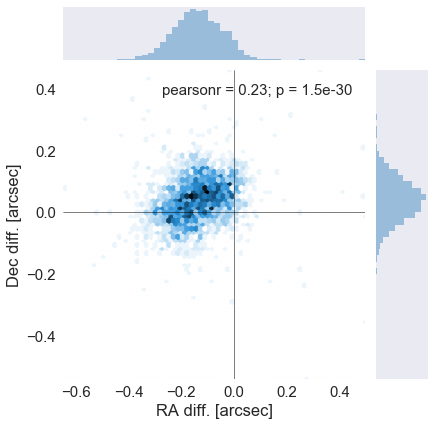

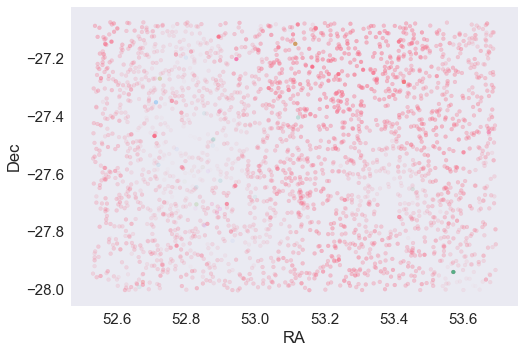

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.1385387621837708 arcsec
Dec correction: -0.04022135406174243 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

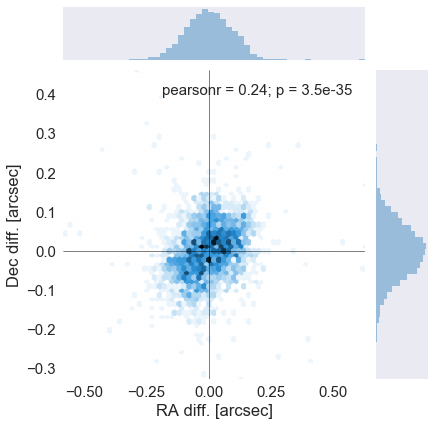

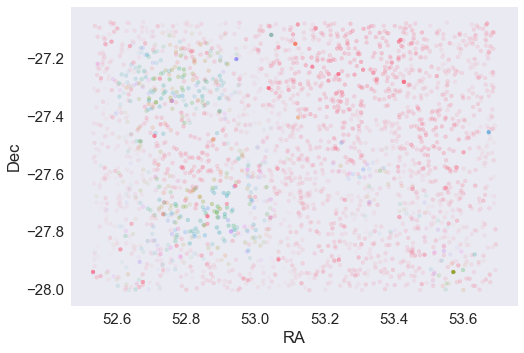

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "ps1_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

2598 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/PS1.fits".format(OUT_DIR), overwrite=True)